In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
import seaborn

In [15]:
dumpAB = torch.load('gradinfo_AB.pth')
dumpBH = torch.load('gradinfo_BH.pth')
grad_sims = dumpAB['grad_sims']
grad_sims1 = dumpBH['grad_sims']

In [38]:
#AB
acc_AB_A = [1.915,5.426,10.106,13.085,19.149,20.319,19.894,23.723,26.170,24.787]
acc_AB_B = [5.591,19.441,28.463,29.352,35.070,31.258,36.595,32.656,36.595,36.341]

#BH
acc_BH_B = [8.259,29.860,36.849,37.357,41.550,39.517,43.456,42.058,42.313,45.743]
acc_BH_H = [8.418,34.056,38.903,45.281,45.153,45.918,47.449,48.214,48.214,47.959]

In [82]:
p_arabacc = {}
p_banacc_AB = {}
#print('gradient cosine and accuracy Correlation scores for ARAB-BAN\n')
for name,sims in grad_sims.items():
    p_arabacc[name]=pearsonr(np.array(acc_AB_A),np.array(sims))[0]
    p_banacc_AB[name]=pearsonr(np.array(acc_AB_B),np.array(sims))[0]
    #print(name)
    #print('correlation between gradient similarity and arab accuracy:',p_arabacc[name])
    #print('correlation between gradient similarity and ban accuracy:',p_banacc_AB[name])
    #print()

In [83]:
p_hinacc = {}
p_banacc = {}
i = 0
#print('gradient cosine and accuracy Correlation scores for Hin-BAN\n')
for name,sims in grad_sims1.items():
    p_hinacc[name]=pearsonr(np.array(acc_BH_H),np.array(sims))[0]
    p_banacc[name]=pearsonr(np.array(acc_BH_B),np.array(sims))[0]
    #print(name)
    #print('correlation between gradient similarity and hindi accuracy:',p_hinacc[name])
    #print('correlation between gradient similarity and ban accuracy:',p_banacc[name])
    #print()

In [49]:
#compute euclidean distance between correlation vectors
def norm1(a,b):
    a = np.array(a)
    b = np.array(b)
    return np.linalg.norm(a-b)

In [56]:
pearson_norm_AB = norm1(p_arabacc,p_banacc_AB)
pearson_norm_BH = norm1(p_hinacc,p_banacc)
pearson_norm_BH_trainAB = norm1(p_hinacc,p_arabacc)
print('norm between pearson correlation vectors of arab and bangla [training on Arab-Bangla]:',pearson_norm_AB)
print('norm between pearson correlation vectors of hindi and bangla [training on Hindi-Bangla]:',pearson_norm_BH)

norm between pearson correlation vectors of arab and bangla [training on Arab-Bangla]: 1.1186875548754143
norm between pearson correlation vectors of hindi and bangla [training on Hindi-Bangla]: 0.19313257876804363


In [28]:
sum(p_banacc)/len(p_banacc)

0.3780566580236156

In [23]:
sum(p_hinacc)/len(p_hinacc)

0.5924139804953318

In [24]:
sum(p_banacc)/len(p_banacc)

0.5873428894708633

In [57]:
def multiplot(opt,x,sims):
    for module in ['FeatureExtraction.','rnn_lang.']:
        for para in ['weight','bias']:
            plot_grad_sim(opt,x,sims,module,para)

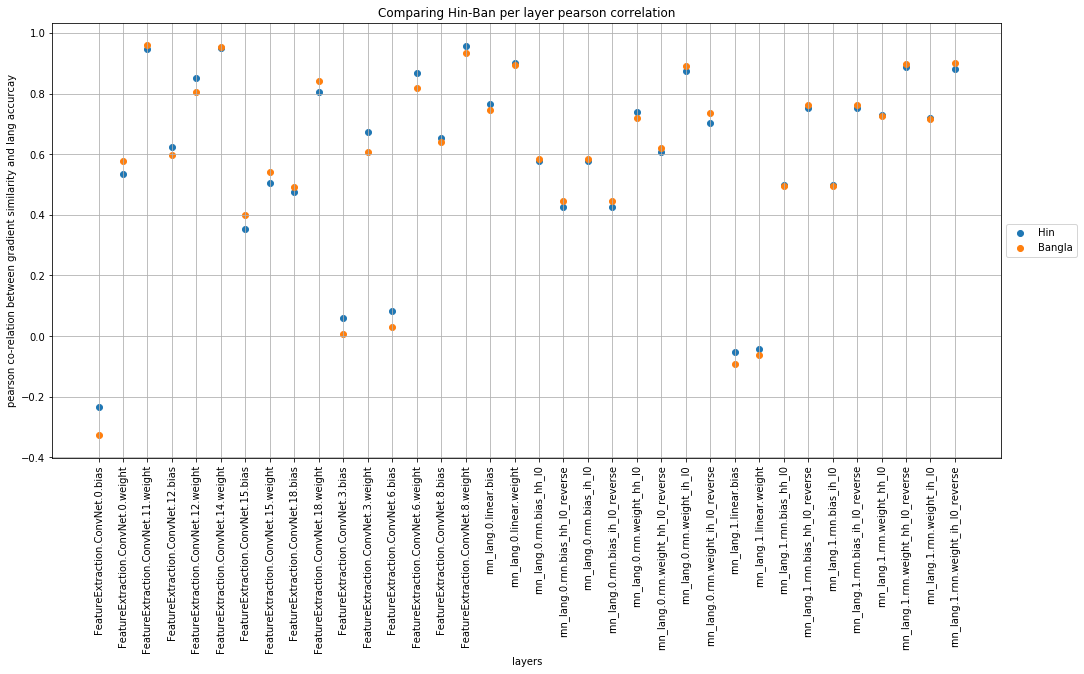

In [80]:
labels = p_hinacc.keys()
values = p_hinacc.values()
fig, axs = plt.subplots(figsize=(20,8))
axs.tick_params(axis='x', rotation=90)
box = axs.get_position()
axs.set_title('Comparing Hin-Ban per layer pearson correlation')
axs.set_position([box.x0, box.y0, box.width * 0.85, box.height])
plt.scatter(list(labels), list(values),label='Hin')
plt.scatter(list(labels),list(p_banacc.values()),label='Bangla')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel('layers')
axs.set_ylabel('pearson co-relation between gradient similarity and lang accurcay')
axs.grid(True)
plt.show()


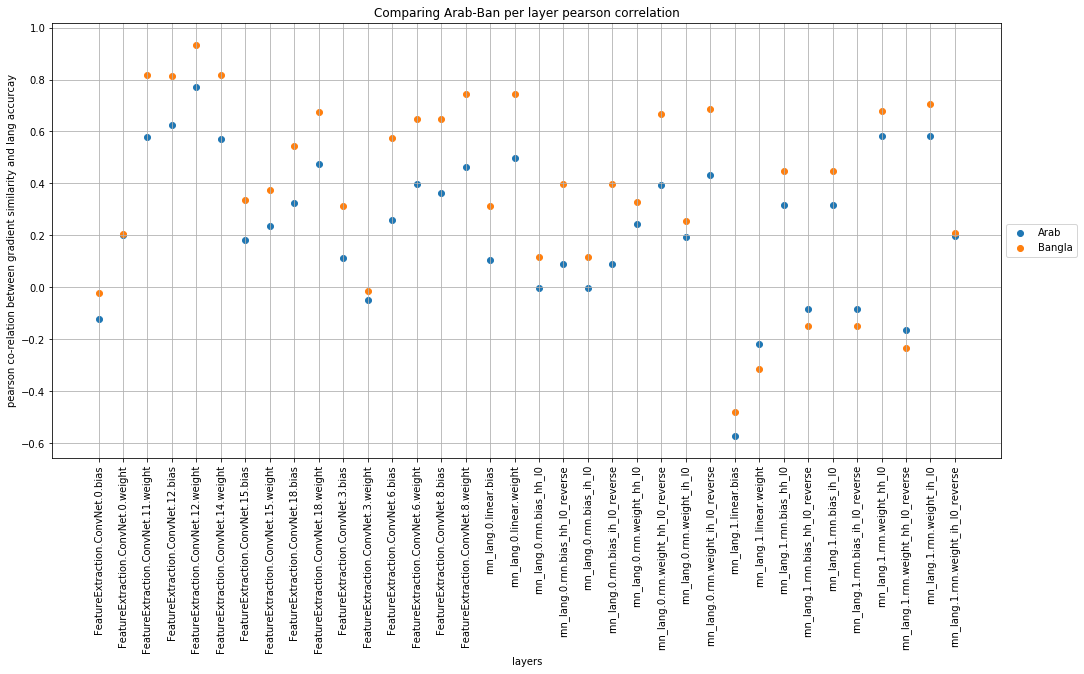

In [79]:
labels = p_hinacc.keys()
values = p_arabacc.values()
fig, axs = plt.subplots(figsize=(20,8))
axs.tick_params(axis='x', rotation=90)
box = axs.get_position()
axs.set_title('Comparing Arab-Ban per layer pearson correlation')
axs.set_position([box.x0, box.y0, box.width * 0.85, box.height])
plt.scatter(list(labels), list(values),label='Arab')
plt.scatter(list(labels),list(p_banacc_AB.values()),label='Bangla')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel('layers')
axs.set_ylabel('pearson co-relation between gradient similarity and lang accurcay')
axs.grid(True)
plt.show()
